In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))

from evaluation import *
from data_loader import *
import random
from datetime import datetime

In [2]:
colors = {
    "DQN": 'darkorange',
    "PPO": 'forestgreen',
    "CMA": 'cyan',
    "ODT": 'blueviolet'
}

In [3]:
experiments = range(1030, 1038)

exp_agent_data = []

agg_counts = []

# REMOVE THIS
algos = ['DQN', 'PPO', 'CMA']
train_types = ['eval', 'train']

for train_type in ['train', 'eval']:
    for ind, exp_num in enumerate(experiments):
        config_fname = f'./Exp_{exp_num}/config.yaml'
        
        c = load_config_file(config_fname)
        nn_c = c['nn_hyperparameters']
        federated_c = c['federated_learning_settings']
        algo_c = c['algorithm_settings']
        env_c = c['environment_settings']
        eval_c = c['eval_config']
    
        ev_info = []
    
        seed = env_c['seed']
    
        algorithm_dm = algo_c['algorithm']
        
        def load_from_json_with_error_handling(filepath, columns_specific):
            try:
                return read_csv_data(filepath, columns=columns_specific)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from {filepath}: {e.msg} at line {e.lineno}, column {e.colno}")
                return None  # Handle the error and return None or an empty object
        
        
        d_base = f"../../../../storage_1/metrics/Exp_{exp_num}"
        
        if not os.path.exists(d_base):
            d_base = f"../metrics/Exp_{exp_num}"
                
        base_path = f"{d_base}/{train_type}/metrics"
    
        print(f'Loading {base_path}_agent_metrics.csv')
        agent_data = load_from_json_with_error_handling(f'{base_path}_agent_metrics.csv', ['episode', 'timestep', 'done', 'zone', 'aggregation', 'agent_index', 'reward',])
        
        agent_data['seed'] = seed
        agent_data['exp_num'] = exp_num
        
        #agent_data['algorithm'] = algorithm_dm
        agent_data['algorithm'] = algos[ind % len(algos)] # REMOVE THIS AND UNCOMMENT PREVIOUS LINE!
    
        #agent_data['train_type'] = train_type
        agent_data['train_type'] = train_types[(ind // len(algos)) % len(train_types)] # REMOVE THIS AND UNCOMMENT PREVIOUS LINE!
        
        agent_data['season'] = env_c['season']    
        agent_data['num_aggs'] = federated_c['aggregation_count']    
        agent_data['eps_per_agg'] = nn_c['num_episodes']
    
        exp_agent_data.append(agent_data)

Loading ../../../../storage_1/metrics/Exp_1030/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_1031/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_1032/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_1033/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_1034/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_1035/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_1036/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_1037/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_1030/eval/metrics_agent_metrics.csv
File ../../../../storage_1/metrics/Exp_1030/eval/metrics_agent_metrics.csv not found.
Loading ../../../../storage_1/metrics/Exp_1031/eval/metrics_agent_metrics.csv
File ../../../../storage_1/metrics/Exp_1031/eval/metrics_agent_metrics.csv not found.
Loading ../../../../storage_1/metrics/Ex

In [4]:
# Convert data to DataFrame for easier manipulation
df_agent = pd.concat(exp_agent_data, ignore_index=True)

cumulative_agent_df = (
    df_agent
    .groupby(
        ['episode', 'zone', 'aggregation', 'agent_index', 'seed', 'exp_num', 'algorithm', 'season', 'train_type', 'eps_per_agg']
    )['reward']
    .sum()
    .reset_index()
)

# Rename the 'reward' column to 'cumulative_reward' for clarity
cumulative_agent_df.rename(columns={'reward': 'cumulative_reward'}, inplace=True)

# Get recalculated episodes using (aggregation number * episodes per aggregation) + episode number
cumulative_agent_df['episode'] = cumulative_agent_df['aggregation'] * cumulative_agent_df['eps_per_agg'] + cumulative_agent_df['episode']

cumulative_agent_df.head()

,episode,zone,aggregation,agent_index,seed,exp_num,algorithm,season,train_type,eps_per_agg,cumulative_reward
0,0.0,1.0,0.0,0.0,1234,1030,DQN,winter,eval,200,-119.092580
1,0.0,1.0,0.0,0.0,1234,1033,DQN,winter,train,200,-104.519553
2,0.0,1.0,0.0,0.0,1234,1034,PPO,winter,train,200,-104.519553
3,0.0,1.0,0.0,0.0,1234,1035,CMA,winter,train,200,-104.519553
4,0.0,1.0,0.0,0.0,1234,1036,DQN,winter,eval,200,-104.519553


In [5]:
cumulative_avg_reward_by_algorithm = (
    cumulative_agent_df
    .groupby(['episode', 'algorithm', 'seed', 'train_type'])['cumulative_reward']
    .mean()
    .reset_index()
)

cumulative_avg_reward_by_algorithm = cumulative_avg_reward_by_algorithm.sort_values(
    ['algorithm', 'seed', 'train_type', 'episode']
)

cumulative_avg_reward_by_algorithm['cumulative_reward'] = (
    cumulative_avg_reward_by_algorithm
    .groupby(['algorithm', 'seed', 'train_type'])['cumulative_reward']
    .transform(lambda x: x.expanding().mean())
)

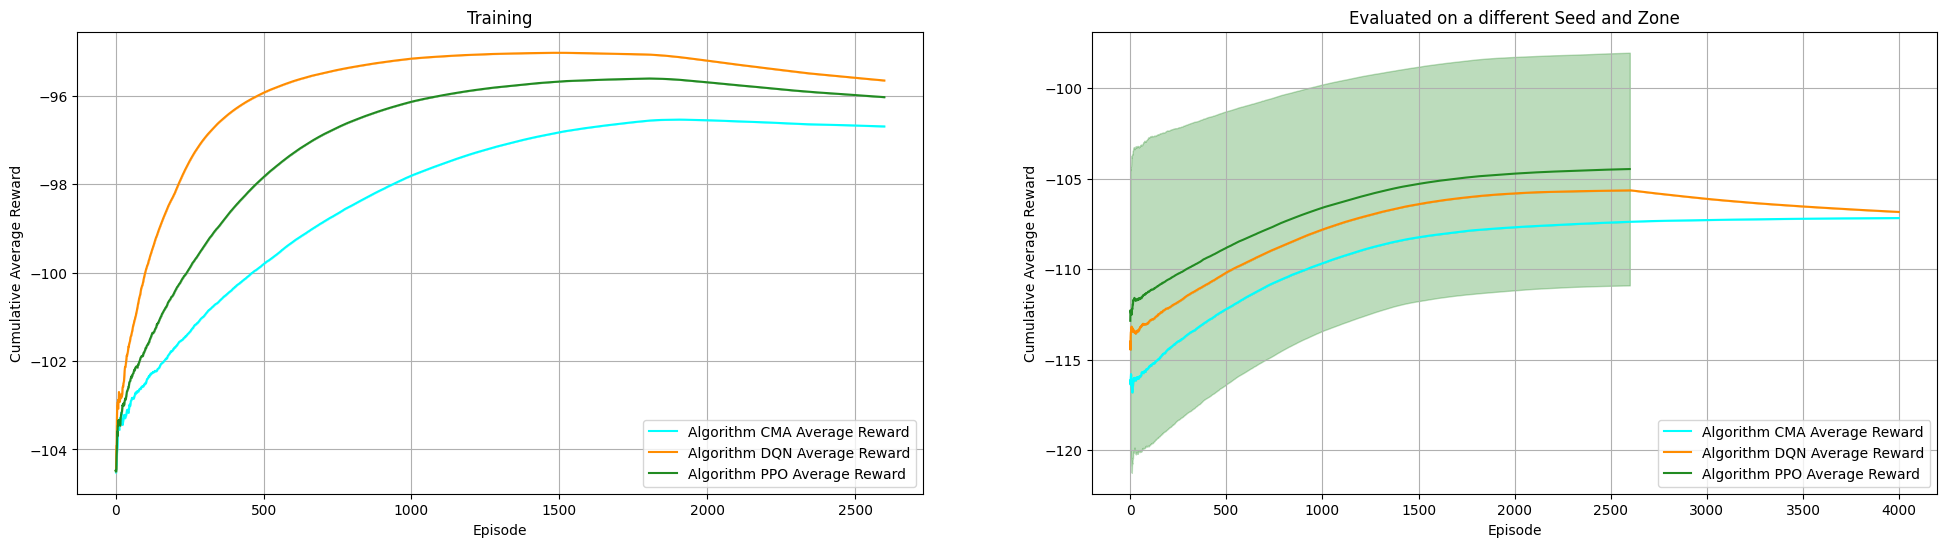

In [7]:
num_plots = len(cumulative_avg_reward_by_algorithm['train_type'].unique())

fig, axes = plt.subplots(1, num_plots, figsize=(24, 6))  # Adjust figsize as needed

for plot_ind, train_type in enumerate(cumulative_avg_reward_by_algorithm['train_type'].unique()):
    ax = axes[plot_ind]
    
    train_type_data = cumulative_avg_reward_by_algorithm.loc[cumulative_avg_reward_by_algorithm['train_type'] == train_type]
        
    for algo in train_type_data['algorithm'].unique():
        # Filter the data for the current zone
        algo_data = train_type_data[train_type_data['algorithm'] == algo]
        
        min_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].min()
        max_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].max()
        mean_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].mean()
    
        ax.fill_between(
            min_cumulative_avg_reward.index, 
            min_cumulative_avg_reward.values, 
            max_cumulative_avg_reward.values,
            color=colors[algo],
            alpha=0.3
        )
        ax.plot(
            mean_cumulative_avg_reward.index, 
            mean_cumulative_avg_reward.values,
            color=colors[algo],
            label=f'Algorithm {algo} Average Reward'
        )
    
    ax.set_xlabel('Episode')
    ax.set_ylabel('Cumulative Average Reward')
    ax.set_title('Training' if train_type == 'train' else 'Evaluated on a different Seed and Zone')
    ax.legend(loc='lower right')
    ax.grid(True)

fig.show()

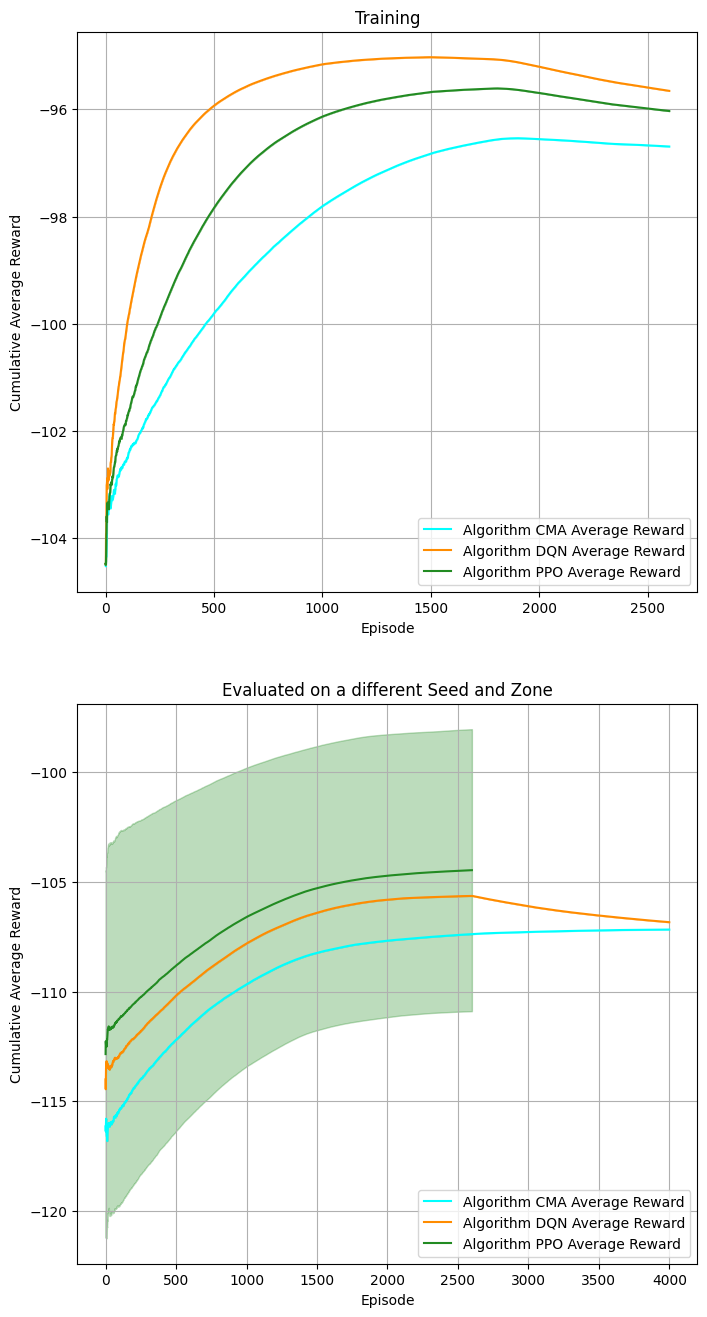

In [8]:
num_plots = len(cumulative_avg_reward_by_algorithm['train_type'].unique())

fig, axes = plt.subplots(num_plots, 1, figsize=(8, 16))  # Adjust figsize as needed

for plot_ind, train_type in enumerate(cumulative_avg_reward_by_algorithm['train_type'].unique()):
    ax = axes[plot_ind]
    
    train_type_data = cumulative_avg_reward_by_algorithm.loc[cumulative_avg_reward_by_algorithm['train_type'] == train_type]
        
    for algo in train_type_data['algorithm'].unique():
        # Filter the data for the current zone
        algo_data = train_type_data[train_type_data['algorithm'] == algo]
        
        min_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].min()
        max_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].max()
        mean_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].mean()
    
        ax.fill_between(
            min_cumulative_avg_reward.index, 
            min_cumulative_avg_reward.values, 
            max_cumulative_avg_reward.values,
            color=colors[algo],
            alpha=0.3
        )
        ax.plot(
            mean_cumulative_avg_reward.index, 
            mean_cumulative_avg_reward.values,
            color=colors[algo],
            label=f'Algorithm {algo} Average Reward'
        )
    
    ax.set_xlabel('Episode')
    ax.set_ylabel('Cumulative Average Reward')
    ax.set_title('Training' if train_type == 'train' else 'Evaluated on a different Seed and Zone')
    ax.legend(loc='lower right')
    ax.grid(True)

fig.show()